In [1]:
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from skimage.color import rgb2gray

import tifffile as TIFF
from matplotlib import cm
from skimage import measure

import PyPlaque
from PyPlaque.experiment import ExperimentFluorescencePlaque
from PyPlaque.phenotypes import Plaque, FluorescencePlaque
from PyPlaque.specimen import (PlaquesImageGray, PlaquesImageRGB, PlaquesMask, PlaquesWell, 
                                PlateImage)
from PyPlaque.utils import centroid, check_numbers, fixed_threshold, stitch_wells, get_plaque_mask, \
      getAllPlaqueRegions, remove_background, remove_artifacts, PlaqueImageReadout

In [2]:
# Here we will pick some random rows from the CSV of matlab results and compare with results from PyPlaque

matlab_results_image = pd.read_csv("../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/200601-zplate-g2_ImageData.csv", header = 0)
matlab_results_object = pd.read_csv("../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/200601-zplate-g2_ObjectData.csv", header = 0)

In [3]:
import scipy.io
mat = scipy.io.loadmat('../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/200601-zplate-g2-params.mat')

In [4]:
params = mat['parameters'][0][0][2][0]
params_names = list(params.dtype.fields.keys())
for i, p in enumerate(params.tolist()[0]):
    print(f'{params_names[i]}:{p}')

artifactThreshold:[[0.5]]
selectedChannel:['w1']
selectedThresholdingMethod:['manualThresholding']
manualThreshold:[[0.008]]
minCellArea:[[80]]
maxCellArea:[[90]]
illuminationCorrectionFlag:[[1]]
correctionBallRadius:[[30]]


In [5]:
params = mat['parameters'][0][0][3][0]
params_names = list(params.dtype.fields.keys())
for i, p in enumerate(params.tolist()[0]):
    print(f'{params_names[i]}:{p}')

selectedChannel:['w2']
virusThreshold:[[0.006]]
minPlaqueArea:[[2000]]
plaqueConnectivity:[[4]]
minCellArea:[[80]]
maxCellArea:[[90]]
finePlaqueDetectionFlag:[[1]]
plaqueGaussianFilterSize:[[100]]
plaqueGaussianFilterSigma:[[50]]
peakRegionSize:[[50]]


In [6]:
matlab_results_image.head()

,NucleiImageName,wellRow,wellCollumn,maxNucleiIntensity,totalNucleiIntensity,meanNucleiIntensity,numberOfNuclei,VirusImageName,maxVirusIntensity,totalVirusIntensity,meanVirusIntensity,medianVirusIntensity,numberOfPlaques,numberOfInfectedNuclei,lesionArea
0,200601-zplate-g2_A01_s1_w1.tif,A,1,30346,7973497550,1901.029956,16530,200601-zplate-g2_A01_s1_w2.tif,23765,5814433448,1386.268961,1691,44,2800,312860
1,200601-zplate-g2_A02_s1_w1.tif,A,2,44135,7829724978,1866.751904,16593,200601-zplate-g2_A02_s1_w2.tif,45051,5974063174,1424.327653,1701,46,2747,323461
2,200601-zplate-g2_A03_s1_w1.tif,A,3,39825,7942540075,1893.649119,16557,200601-zplate-g2_A03_s1_w2.tif,30736,6097916446,1453.856575,1728,55,3335,419047
3,200601-zplate-g2_A04_s1_w1.tif,A,4,32732,7830277569,1866.883652,16701,200601-zplate-g2_A04_s1_w2.tif,24285,5957118217,1420.287661,1691,41,2739,362001
4,200601-zplate-g2_A05_s1_w1.tif,A,5,65535,7893285205,1881.905843,16142,200601-zplate-g2_A05_s1_w2.tif,40158,5914820990,1410.203216,1687,40,2677,335227


In [7]:
matlab_results_object.head()

,wellRow,wellCollumn,Area,Centroid_1,Centroid_2,BoundingBox_1,BoundingBox_2,BoundingBox_3,BoundingBox_4,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Roundness,numberOfPeaks,numberOfNucleiInPlaque,numberOfInfectedNucleiInPlaque,maxIntensityGFP,totalIntensityGFP,meanIntensity
0,A,1,6648,175.514892,406.206679,105.5,260.5,135,240,147.035749,73.567958,0.865829,13423,0.508389,1,95,48,5545,37690110,1163.275000
1,A,1,5305,130.836004,669.178699,106.5,587.5,74,205,186.650440,56.178561,0.953630,10454,0.558406,1,54,36,4169,28246053,1861.967897
2,A,1,4374,228.662780,1025.294010,129.5,977.5,150,105,126.508280,90.956945,0.695031,11396,0.790887,1,46,37,9056,31443998,1996.444317
3,A,1,4177,351.801293,1051.497486,285.5,1007.5,157,98,132.495795,71.550745,0.841650,11944,0.833715,1,42,35,9554,30349564,1972.544131
4,A,1,4479,370.533825,348.429560,329.5,305.5,85,88,86.634725,68.647576,0.610029,5385,0.936452,1,31,28,6256,19163200,2561.925134


In [8]:
channel_1_identifier = 'w1'
channel_2_identifier = 'w2'

In [9]:
# Sampling a bunch of rows from the two datasets
matlab_results_image_w2 = matlab_results_image.loc[matlab_results_image['VirusImageName'].str. \
                                                   contains(channel_2_identifier, case=True)]
print(matlab_results_image_w2.shape)
sample_matlab_results_image_w2 = matlab_results_image_w2.sample(n=20, replace=False, random_state=1)
print(sample_matlab_results_image_w2.shape)

(384, 15)
(20, 15)


In [10]:
#Now we will try to find the corresponding images and process them 
#For images it is easy since we only need to indentify the well which is easy from the image name 
#itself, for objects it is a bit difficult since we need to lookup and match the centroid

#loading multiple plates and plate masks as an experiment
exp = ExperimentFluorescencePlaque('../../data/samples_fluorescent_plaques/images',
                                   '../../data/samples_fluorescent_plaques/masks')

#In this case the individual plates are of 384 well plates for fluorescence plaques and 
#their corresponding mask directories
plate_dirs, plate_mask_dirs = exp.get_individual_plates()

print(plate_dirs, plate_mask_dirs)

print(exp.get_number_of_plates())
#This number is accurate but we are choosing to ignore other plates other than just one  

['200601-zplate-g2', '200528-zplate-g1'] ['200601-zplate-g2', '200528-zplate-g1']
2


In [11]:
image_bits = 16
virus_params = {
    'min_plaque_area': 2000,
    'virus_threshold': 0.006 * (2**image_bits - 1),
    #'virus_threshold': 0.03 * (2**image_bits - 1),
    'plaque_connectivity': 4,
    'fine_plaque_detection_flag': True,
    #'plaque_gaussian_filter_size': 150,
    'plaque_gaussian_filter_size': 100,
    'plaque_gaussian_filter_sigma': 50,
    'peak_region_size': 50,
    'minCellArea': 80,
    'maxCellArea': 90,
    'correctionBallRadius': 30
}

plate_dict_w2 = {}

d = plate_dirs[0]

i = 1
plate_dict_w2[d] = {}
plate_dict_w2[d]['img'] = {}
plate_dict_w2[d]['mask'] = {}
plate_dict_w2[d]['image_name'] = {}
image_files_for_comparison = list(sample_matlab_results_image_w2['VirusImageName'])
image_files_for_comparison = [os.path.join(exp.plate_folder,d,'2020-06-03','2072',f)
                                for f in image_files_for_comparison]
for f in image_files_for_comparison:
    print(f)
    plate_dict_w2[d]['img'][i] = TIFF.imread(f)
    # print(plate_dict_w2[d]['img'][i].shape)
    plate_dict_w2[d]['image_name'][i] = f
    # print(plate_dict_w2[d]['image_name'][i])
    #bg, bg_removed_img = remove_background(plate_dict_w2[d]['img'][i],
    #                          radius=virus_params['correctionBallRadius'])
    #plate_dict_w2[d]['mask'][i] = get_plaque_mask(bg_removed_img,virus_params)[0]
    plate_dict_w2[d]['mask'][i] = get_plaque_mask(plate_dict_w2[d]['img'][i],virus_params)[0]
    # print(plate_dict_w2[d]['mask'][i].shape)
    i+=1
        

../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_K17_s1_w2.tif
../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_E11_s1_w2.tif
../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_F03_s1_w2.tif
../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_C15_s1_w2.tif
../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_H18_s1_w2.tif
../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_L20_s1_w2.tif
../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_F20_s1_w2.tif
../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_D24_s1_w2.tif
../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_K19_s1_w2.tif
../../data

In [12]:
matlab_results_image.loc[(matlab_results_image['wellRow']=='C')&(matlab_results_image['wellCollumn']==15)]

,NucleiImageName,wellRow,wellCollumn,maxNucleiIntensity,totalNucleiIntensity,meanNucleiIntensity,numberOfNuclei,VirusImageName,maxVirusIntensity,totalVirusIntensity,meanVirusIntensity,medianVirusIntensity,numberOfPlaques,numberOfInfectedNuclei,lesionArea
62,200601-zplate-g2_C15_s1_w1.tif,C,15,65535,7605115973,1813.200944,15660,200601-zplate-g2_C15_s1_w2.tif,10440,5242089931,1249.811633,1622,2,318,4958


../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_C15_s1_w2.tif


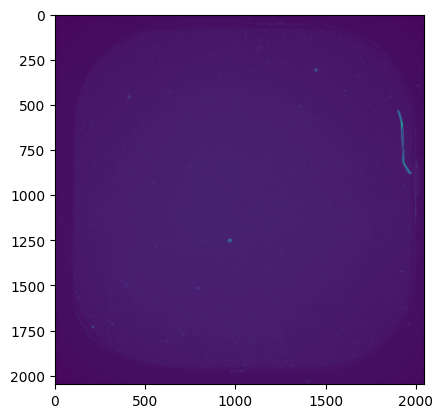

In [13]:
print(plate_dict_w2['200601-zplate-g2']['image_name'][4])
plt.imshow(plate_dict_w2['200601-zplate-g2']['img'][4])

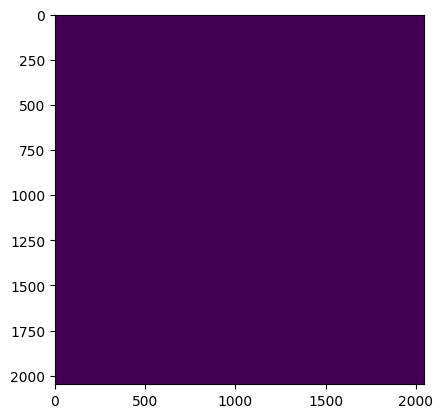

In [14]:
plt.imshow(plate_dict_w2['200601-zplate-g2']['mask'][4])

In [15]:
img_list_w2 = list(plate_dict_w2[plate_dirs[0]]['img'].values())
len(img_list_w2)

20

In [16]:
image_bits = 16
nuclei_params = {
    'min_plaque_area': 2000,
    # 'virus_threshold': 0.008 * (2**image_bits - 1),
    'virus_threshold': 0.08 * (2**image_bits - 1),
    'artifact_threshold': 0.5 * (2**image_bits - 1),
    'plaque_connectivity': 6,
    'fine_plaque_detection_flag': True,
    'plaque_gaussian_filter_size': 90,
    'plaque_gaussian_filter_sigma': 30,
    'peak_region_size': 10,
    'minCellArea': 80,
    'maxCellArea': 90,
    'correctionBallRadius': 30
}


plate_dict_w1 = {}

d = plate_dirs[0]

i = 1
plate_dict_w1[d] = {}
plate_dict_w1[d]['img'] = {}
plate_dict_w1[d]['mask'] = {}
plate_dict_w1[d]['image_name'] = {}
image_files_for_comparison = list(sample_matlab_results_image_w2['NucleiImageName'])
image_files_for_comparison = [os.path.join(exp.plate_folder,d,'2020-06-03','2072',f)
                                for f in image_files_for_comparison]
for f in image_files_for_comparison:
    print(f)
    plate_dict_w1[d]['img'][i] = TIFF.imread(f)
    # print(plate_dict_w1[d]['img'][i].shape)
    plate_dict_w1[d]['image_name'][i] = f
    # print(plate_dict_w1[d]['image_name'][i])
    artifact_removed_img = remove_artifacts(plate_dict_w1[d]['img'][i],
                                        artifact_threshold=nuclei_params['artifact_threshold'])
    bg, bg_removed_img = remove_background(artifact_removed_img,
                        radius=nuclei_params['correctionBallRadius'])
    # change to regular thresholding
    bg_removed_img[bg_removed_img > nuclei_params['virus_threshold']] = 1
    bg_removed_img[bg_removed_img <= nuclei_params['virus_threshold']] = 0
    plate_dict_w1[d]['mask'][i] = bg_removed_img
    # plate_dict_w1[d]['mask'][i] = get_plaque_mask(bg_removed_img,nuclei_params)[0]
    # print(plate_dict_w1[d]['mask'][i].shape)
    i+=1


../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_K17_s1_w1.tif
../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_E11_s1_w1.tif
../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_F03_s1_w1.tif
../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_C15_s1_w1.tif
../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_H18_s1_w1.tif
../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_L20_s1_w1.tif
../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_F20_s1_w1.tif
../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_D24_s1_w1.tif
../../data/samples_fluorescent_plaques/images/200601-zplate-g2/2020-06-03/2072/200601-zplate-g2_K19_s1_w1.tif
../../data

In [17]:
img_list_w1 = list(plate_dict_w1[plate_dirs[0]]['img'].values())
len(img_list_w1)

20

In [18]:
differences_df_image = pd.DataFrame()
differences_df_image['NucleiImageName'] = sample_matlab_results_image_w2['NucleiImageName']
differences_df_image['VirusImageName'] = sample_matlab_results_image_w2['VirusImageName']


In [19]:
def diff_perc(a,b):
    if a==0 and b==0:
        return 0
    elif a==0:
        return 0
    else:
        return (a-b)*100/a
    
def diff_fold(a,b):
    if a==0 and b==0:
        return 1
    elif b==0:
        return 0
    else:
        return a/b

In [20]:
#Generating readouts for images as in PyPlaque in Matlab
#Assuming that w1 is the nuclei channel and w2 as the plaque channel


max_nuclei_intensity_diff = []
total_nuclei_intensity_diff = []
mean_nuclei_intensity_diff = []
nuclei_count_diff = []
max_plaque_intensity_diff = []
total_plaque_intensity_diff = []
mean_plaque_intensity_diff = []
median_plaque_intensity_diff = []
plaque_count_diff = []
infected_nuclei_count_diff = []
lesion_area_diff = []

for i in range(len(img_list_w2)):
    print(i)
    plq_image_readout = PlaqueImageReadout(nuclei_image_name=plate_dict_w1['200601-zplate-g2']
                                        ['image_name'][i+1].split("/")[-1],
                            plaque_image_name=plate_dict_w2['200601-zplate-g2']['image_name'][i+1].split("/")[-1],
                            nuclei_image=np.array(plate_dict_w1['200601-zplate-g2']['img'][i+1]),
                            plaque_image=np.array(plate_dict_w2['200601-zplate-g2']['img'][i+1]),
                            nuclei_mask=np.array(plate_dict_w1['200601-zplate-g2']['mask'][i+1]),
                            plaque_mask=np.array(plate_dict_w2['200601-zplate-g2']['mask'][i+1]),
                            virus_params = virus_params)
    
    max_nuclei_intensity_diff.append(diff_fold(
                                    sample_matlab_results_image_w2['maxNucleiIntensity'].iloc[i] , 
                                    plq_image_readout.get_max_nuclei_intensity()))
    total_nuclei_intensity_diff.append(diff_fold(
                                    sample_matlab_results_image_w2['totalNucleiIntensity'].iloc[i] , 
                                    plq_image_readout.get_total_nuclei_intensity()))
    mean_nuclei_intensity_diff.append(diff_fold(
                                    sample_matlab_results_image_w2['meanNucleiIntensity'].iloc[i] , 
                                    plq_image_readout.get_mean_nuclei_intensity()))
    nuclei_count_diff.append(diff_fold(
                                    sample_matlab_results_image_w2['numberOfNuclei'].iloc[i] , 
                                    plq_image_readout.get_nuclei_count()))
    max_plaque_intensity_diff.append(diff_fold(
                                    sample_matlab_results_image_w2['maxVirusIntensity'].iloc[i] , 
                                    plq_image_readout.get_max_plaque_intensity()))
    total_plaque_intensity_diff.append(diff_fold(
                                    sample_matlab_results_image_w2['totalVirusIntensity'].iloc[i] , 
                                    plq_image_readout.get_total_plaque_intensity()))
    mean_plaque_intensity_diff.append(diff_fold(
                                    sample_matlab_results_image_w2['meanVirusIntensity'].iloc[i] , 
                                    plq_image_readout.get_mean_plaque_intensity()))
    median_plaque_intensity_diff.append(diff_fold(
                                    sample_matlab_results_image_w2['medianVirusIntensity'].iloc[i] , 
                                    plq_image_readout.get_median_plaque_intensity()))
    plaque_count_diff.append(diff_fold(
                                    sample_matlab_results_image_w2['numberOfPlaques'].iloc[i] , 
                                    plq_image_readout.get_plaque_count()))
    infected_nuclei_count_diff.append(diff_fold(
                                    sample_matlab_results_image_w2['numberOfInfectedNuclei'].iloc[i] ,
                                    plq_image_readout.get_infected_nuclei_count()))
    lesion_area_diff.append(diff_fold(
                                    sample_matlab_results_image_w2['lesionArea'].iloc[i] , 
                                    plq_image_readout.get_lesion_area()))



#Maybe it would be good to have a percentage point difference

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [21]:
plq_image_readout = PlaqueImageReadout(nuclei_image_name=plate_dict_w1['200601-zplate-g2']
                                        ['image_name'][3+1].split("/")[-1],
                            plaque_image_name=plate_dict_w2['200601-zplate-g2']['image_name'][3+1].split("/")[-1],
                            nuclei_image=np.array(plate_dict_w1['200601-zplate-g2']['img'][3+1]),
                            plaque_image=np.array(plate_dict_w2['200601-zplate-g2']['img'][3+1]),
                            nuclei_mask=np.array(plate_dict_w1['200601-zplate-g2']['mask'][3+1]),
                            plaque_mask=np.array(plate_dict_w2['200601-zplate-g2']['mask'][3+1]),
                            virus_params = virus_params)
print(diff_fold(sample_matlab_results_image_w2['numberOfPlaques'].iloc[3] , 
                plq_image_readout.get_plaque_count()))
print(plq_image_readout.get_row(),plq_image_readout.get_column())
print(sample_matlab_results_image_w2['wellRow'].iloc[3],
      sample_matlab_results_image_w2['wellCollumn'].iloc[3])
print(plq_image_readout.get_plaque_count())
print(sample_matlab_results_image_w2['numberOfPlaques'].iloc[3])

2.0
C 15
C 15
1
2


In [22]:
differences_df_image['maxNucleiIntensity'] = max_nuclei_intensity_diff
differences_df_image['totalNucleiIntensity'] = total_nuclei_intensity_diff
differences_df_image['meanNucleiIntensity'] = mean_nuclei_intensity_diff
differences_df_image['numberOfNuclei'] = nuclei_count_diff
differences_df_image['maxVirusIntensity'] = max_plaque_intensity_diff
differences_df_image['totalVirusIntensity'] = total_plaque_intensity_diff
differences_df_image['meanVirusIntensity'] = mean_plaque_intensity_diff
differences_df_image['medianVirusIntensity'] = median_plaque_intensity_diff
differences_df_image['numberOfPlaques'] = plaque_count_diff
differences_df_image['numberOfInfectedNuclei'] = infected_nuclei_count_diff
differences_df_image['lesionArea'] = lesion_area_diff


In [23]:
differences_df_image

,NucleiImageName,VirusImageName,maxNucleiIntensity,totalNucleiIntensity,meanNucleiIntensity,numberOfNuclei,maxVirusIntensity,totalVirusIntensity,meanVirusIntensity,medianVirusIntensity,numberOfPlaques,numberOfInfectedNuclei,lesionArea
256,200601-zplate-g2_K17_s1_w1.tif,200601-zplate-g2_K17_s1_w2.tif,0,0,0,0,1.000000,0.785827,1.213515,1.577919,0.0,0.005860,0.000000
106,200601-zplate-g2_E11_s1_w1.tif,200601-zplate-g2_E11_s1_w2.tif,0,0,0,0,1.000000,0.795369,1.330854,1.599414,44.0,0.052473,0.077449
122,200601-zplate-g2_F03_s1_w1.tif,200601-zplate-g2_F03_s1_w2.tif,0,0,0,0,0.959975,0.792892,1.322287,1.595506,48.0,0.044099,0.076745
62,200601-zplate-g2_C15_s1_w1.tif,200601-zplate-g2_C15_s1_w2.tif,0,0,0,0,1.000000,0.788315,1.221115,1.584758,2.0,0.006448,0.001182
185,200601-zplate-g2_H18_s1_w1.tif,200601-zplate-g2_H18_s1_w2.tif,0,0,0,0,1.000000,0.786202,1.245771,1.611138,1.0,0.005799,0.000555
283,200601-zplate-g2_L20_s1_w1.tif,200601-zplate-g2_L20_s1_w2.tif,0,0,0,0,0.782538,0.784075,1.222111,1.588666,1.0,0.006265,0.000483
139,200601-zplate-g2_F20_s1_w1.tif,200601-zplate-g2_F20_s1_w2.tif,0,0,0,0,1.000000,0.785814,1.215691,1.579873,1.0,0.006448,0.000755
95,200601-zplate-g2_D24_s1_w1.tif,200601-zplate-g2_D24_s1_w2.tif,0,0,0,0,1.000000,0.792488,1.267818,1.647289,0.0,0.005150,0.000000
258,200601-zplate-g2_K19_s1_w1.tif,200601-zplate-g2_K19_s1_w2.tif,0,0,0,0,0.357618,0.785270,1.216040,1.579873,0.0,0.006427,0.000000
127,200601-zplate-g2_F08_s1_w1.tif,200601-zplate-g2_F08_s1_w2.tif,0,0,0,0,1.000000,0.797008,1.326108,1.609184,45.0,0.050141,0.078555


In [24]:
iter = len(differences_df_image)
quants = list(differences_df_image.columns)
quants.pop(0)
quants.pop(0)
print(quants)
print(len(quants))
diff_perc_iter_ls  = np.array([list(differences_df_image[quant]) for quant in quants]).flatten()

diff_perc_df = pd.DataFrame({
        "Values": diff_perc_iter_ls,
        "Quant": np.array([[quant]*iter for quant in quants]).flatten()
    })

['maxNucleiIntensity', 'totalNucleiIntensity', 'meanNucleiIntensity', 'numberOfNuclei', 'maxVirusIntensity', 'totalVirusIntensity', 'meanVirusIntensity', 'medianVirusIntensity', 'numberOfPlaques', 'numberOfInfectedNuclei', 'lesionArea']
11


In [25]:
def barplot_info_loss(diff_df, save_path=None):
    sns.set(font_scale=1.5)
    sns.set_style("ticks")
    sns.barplot(
        x="Quant",
        y="Values",
        data=diff_df,
        errorbar="sd",
        capsize=.2,
        color='black',edgecolor='black'
    ).set(xlabel='Quants', ylabel='Fold Difference')
    plt.xticks(rotation=90)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()
    return

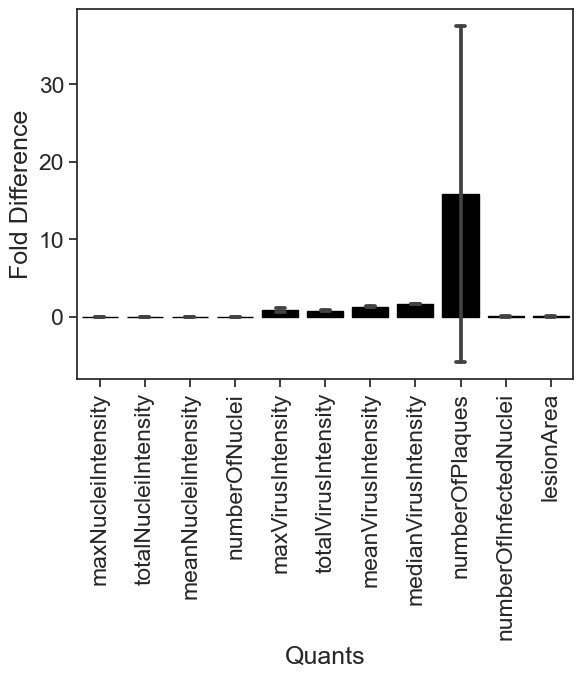

In [27]:
barplot_info_loss(diff_perc_df)

In [26]:
def lookup_objects(df, plq_object_readout):
    filtered_df = df.loc[
        matlab_results_object['wellCollumn'].str.contains(plq_object_readout.get_column(), 
                                                          case=True)]
    
    filtered_df = filtered_df.loc[
        matlab_results_object['wellRow'].str.contains(plq_object_readout.get_row(), case=True)]
    
    #Y
    df_closest = filtered_df.iloc[(
        filtered_df['Centroid_1']-plq_object_readout.get_centroid()[0]).abs().argsort()[:1]]

    #X
    df_closest = df_closest.iloc[(
        df_closest['Centroid_2']-plq_object_readout.get_centroid()[1]).abs().argsort()[:1]]
    return df_closest


In [27]:
differences_df_object = pd.DataFrame()


In [28]:
matlab_results_object['wellCollumn'] = matlab_results_object['wellCollumn'].apply(str)

In [29]:
#Now for the readouts at the object level
well_row = []
well_column = []
area_diff = []
centroid_1_diff = []
centroid_2_diff = []
bbox_1_diff = []
bbox_2_diff = []
bbox_3_diff = []
bbox_4_diff = []
major_axis_length_diff = []
minor_axis_length_diff = []
eccentricity_diff = []
convex_area_diff = []
roundness_diff = []
peak_counts_diff = []
nuclei_in_plaque_diff = []
infected_nuclei_in_plaque_diff = []
max_intensity_GFP_diff = []
total_intensity_GFP_diff = []
mean_intensity_GFP_diff = []

for i in range(len(img_list_w2)):
    print(i)
    plq_image_readout = PlaqueImageReadout(nuclei_image_name=plate_dict_w1['200601-zplate-g2']
                                        ['image_name'][i+1].split("/")[-1],
                            plaque_image_name=plate_dict_w2['200601-zplate-g2']['image_name'][i+1].split("/")[-1],
                            nuclei_image=np.array(plate_dict_w1['200601-zplate-g2']['img'][i+1]),
                            plaque_image=np.array(plate_dict_w2['200601-zplate-g2']['img'][i+1]),
                            nuclei_mask=np.array(plate_dict_w1['200601-zplate-g2']['mask'][i+1]),
                            plaque_mask=np.array(plate_dict_w2['200601-zplate-g2']['mask'][i+1]),
                            virus_params=virus_params)
    # print(plate_dict_w1['200601-zplate-g2']['image_name'][i+1])
    plq_objects = plq_image_readout.get_plaque_objects()
    # print(len(plq_objects))
    if len(plq_objects)==0:
        continue
    random_plq_id = np.random.randint(low=0, high =len(plq_objects),size=1)
    # print(random_plq_id)
    plq_object_readout = plq_image_readout.call_plaque_object_readout(plq_objects[random_plq_id[0]],
                                                                      virus_params)

    df_closest = lookup_objects(matlab_results_object,plq_object_readout)
    # print(df_closest)

    if len(df_closest)==0:
        continue
    well_row.append(plq_object_readout.get_row())
    well_column.append(plq_object_readout.get_column())
    area_diff.append(diff_fold(df_closest['Area'].iloc[0], plq_object_readout.get_area()))
    centroid_1_diff.append(diff_fold(df_closest['Centroid_1'].iloc[0],
                                     plq_object_readout.get_centroid()[0]))
    centroid_2_diff.append(diff_fold(df_closest['Centroid_2'].iloc[0],
                                     plq_object_readout.get_centroid()[1]))
    bbox_1_diff.append(diff_fold(df_closest['BoundingBox_1'].iloc[0],
                                 plq_object_readout.get_bbox()[0]))
    bbox_2_diff.append(diff_fold(df_closest['BoundingBox_2'].iloc[0],
                                 plq_object_readout.get_bbox()[1]))
    bbox_3_diff.append(diff_fold(df_closest['BoundingBox_3'].iloc[0],
                                 plq_object_readout.get_bbox()[2]))
    bbox_4_diff.append(diff_fold(df_closest['BoundingBox_4'].iloc[0],
                                 plq_object_readout.get_bbox()[3]))
    major_axis_length_diff.append(diff_fold(df_closest['MajorAxisLength'].iloc[0],
                                            plq_object_readout.get_major_minor_axis_length()[0]))
    minor_axis_length_diff.append(diff_fold(df_closest['MinorAxisLength'].iloc[0],
                                            plq_object_readout.get_major_minor_axis_length()[1]))
    eccentricity_diff.append(diff_fold(df_closest['Eccentricity'].iloc[0],
                                       plq_object_readout.get_eccentricity()))
    convex_area_diff.append(diff_fold(df_closest['ConvexArea'].iloc[0],
                                      plq_object_readout.get_convex_area()))
    roundness_diff.append(diff_fold(df_closest['Roundness'].iloc[0],plq_object_readout.roundness()))
    peak_counts_diff.append(diff_fold(df_closest['numberOfPeaks'].iloc[0],
                                    len(plq_object_readout.get_number_of_peaks())))
    nuclei_in_plaque_diff.append(diff_fold(df_closest['numberOfNucleiInPlaque'].iloc[0],
                                            plq_object_readout.get_nuclei_in_plaque()))
    infected_nuclei_in_plaque_diff.append(diff_fold(df_closest['numberOfInfectedNucleiInPlaque'].iloc[0],
                                                    plq_object_readout.get_infected_nuclei_in_plaque()))
    max_intensity_GFP_diff.append(diff_fold(df_closest['maxIntensityGFP'].iloc[0],
                                            plq_object_readout.get_max_intensity_GFP()))
    total_intensity_GFP_diff.append(diff_fold(df_closest['totalIntensityGFP'].iloc[0],
                                                plq_object_readout.get_total_intensity_GFP()))
    mean_intensity_GFP_diff.append(diff_fold(df_closest['meanIntensity'].iloc[0],
                                                plq_object_readout.get_mean_intensity_GFP()))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [30]:
print(matlab_results_object.columns)

Index(['wellRow', 'wellCollumn', 'Area', 'Centroid_1', 'Centroid_2',
       'BoundingBox_1', 'BoundingBox_2', 'BoundingBox_3', 'BoundingBox_4',
       'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'ConvexArea',
       'Roundness', 'numberOfPeaks', 'numberOfNucleiInPlaque',
       'numberOfInfectedNucleiInPlaque', 'maxIntensityGFP',
       'totalIntensityGFP', 'meanIntensity'],
      dtype='object')


In [31]:
differences_df_object['wellRow'] = well_row
differences_df_object['wellCollumn'] = well_column
differences_df_object['Area'] = area_diff
differences_df_object['Centroid_1'] = centroid_1_diff
differences_df_object['Centroid_2'] = centroid_2_diff
differences_df_object['BoundingBox_1'] = bbox_1_diff
differences_df_object['BoundingBox_2'] = bbox_2_diff
differences_df_object['BoundingBox_3'] = bbox_3_diff
differences_df_object['BoundingBox_4'] = bbox_4_diff
differences_df_object['MajorAxisLength'] = major_axis_length_diff
differences_df_object['MinorAxisLength'] = minor_axis_length_diff
differences_df_object['Eccentricity'] = eccentricity_diff
differences_df_object['ConvexArea'] = convex_area_diff
differences_df_object['Roundness'] = roundness_diff
differences_df_object['numberOfPeaks'] = peak_counts_diff
differences_df_object['numberOfNucleiInPlaque'] = nuclei_in_plaque_diff
differences_df_object['numberOfInfectedNucleiInPlaque'] = infected_nuclei_in_plaque_diff
differences_df_object['maxIntensityGFP'] = max_intensity_GFP_diff
differences_df_object['totalIntensityGFP'] = total_intensity_GFP_diff
differences_df_object['meanIntensity'] = mean_intensity_GFP_diff

In [32]:
differences_df_object.shape

(5, 20)

In [33]:
iter = len(differences_df_object)
quants = list(differences_df_object.columns)
quants.pop(0)
quants.pop(0)
print(quants)
print(len(quants))
diff_perc_iter_ls  = np.array([list(differences_df_object[quant]) for quant in quants]).flatten()

diff_perc_df = pd.DataFrame({
        "Values": diff_perc_iter_ls,
        "Quant": np.array([[quant]*iter for quant in quants]).flatten()
    })

['Area', 'Centroid_1', 'Centroid_2', 'BoundingBox_1', 'BoundingBox_2', 'BoundingBox_3', 'BoundingBox_4', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'ConvexArea', 'Roundness', 'numberOfPeaks', 'numberOfNucleiInPlaque', 'numberOfInfectedNucleiInPlaque', 'maxIntensityGFP', 'totalIntensityGFP', 'meanIntensity']
18


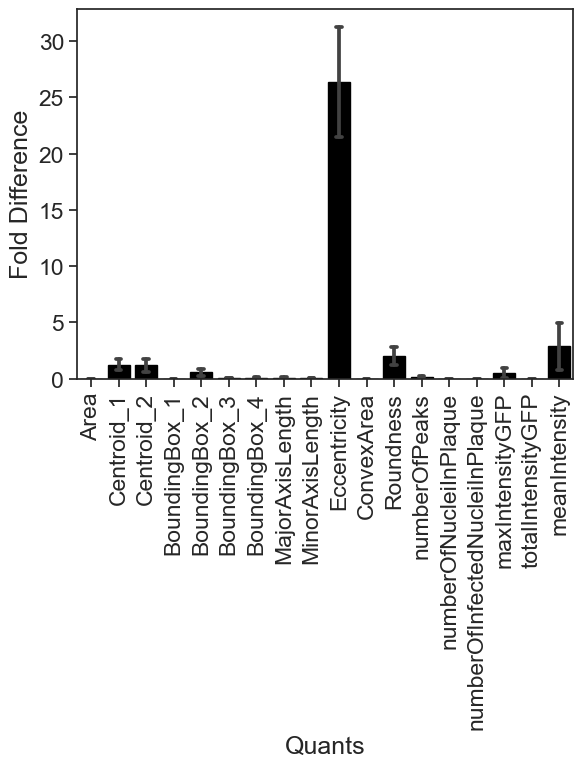

In [34]:
barplot_info_loss(diff_perc_df)

#### ROUGH WORK

NameError: name 'virus_params_w2' is not defined

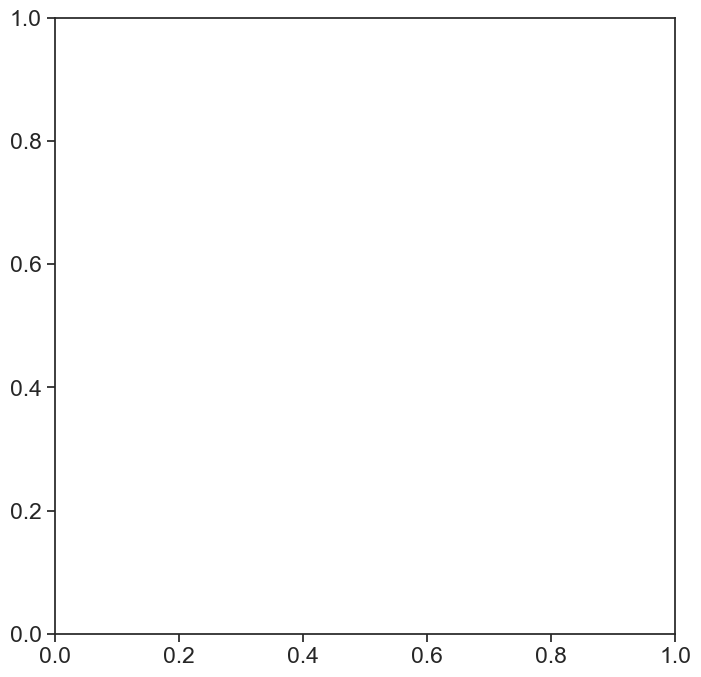

In [52]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(get_plaque_mask(TIFF.imread(os.path.join(exp.plate_folder,d,'2020-06-03','2072','200601-zplate-g2_J17_s1_w2.tif')),virus_params_w2)[0],cmap='gray')
plt.show()